In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from numpy.typing import NDArray
from plot_shift.profit_based_thresholds_plot import (
    calculate_profit_thresholds,
    plot_profit_thresholds,
)
from tabulate import tabulate
from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from mads_telemarketing_assignment.config import (
    NOT_APPROACHED_DATA_FILENAME,
    CATEGORICAL_FEATURES,
    PROCESSED_DATA_DIR,
)

In [2]:
# Various package configurations
plt.style.use("seaborn-v0_8-darkgrid")

In [3]:
# Various variables used in the code
random_state = 42

In [4]:
# Load approached dataset
df = pd.read_csv(PROCESSED_DATA_DIR / NOT_APPROACHED_DATA_FILENAME)

In [5]:
# Define X and y for modeling
X = df.drop(columns=["y"], axis=1)
y = df["y"]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (39673, 17), y shape: (39673,)


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_state,
    shuffle=False, # Shuffle the data before splitting
    test_size=len(X[X['year'] == 2010]), # Take all instances from year 2010 as test set
)

# Convert to numpy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [7]:
# Transform features to prepare for modelling
transformer = ColumnTransformer(
    [
        (
            "categorical",
            OneHotEncoder(
                sparse_output=False,
                handle_unknown="ignore",
            ),
            [col for col in CATEGORICAL_FEATURES if col != "poutcome"],
        ),
    ],
    remainder=MinMaxScaler(),
)
X_train_transformed = transformer.fit_transform(X_train)

In [8]:
# Define list of classifiers to be used in modeling process
classifiers = {
    "AdaBoost": [
        AdaBoostClassifier(random_state=random_state),
        {
            # "learning_rate": [1, 0.1, 0.01],
        },
    ],
    "Gradient Boosting": [
        GradientBoostingClassifier(random_state=random_state),
        {
            # "max_depth": [3, 5, 7],
        },
    ],
    "K-Nearest Neighbors": [
        KNeighborsClassifier(n_jobs=-1),
        {
            # "n_neighbors": [3, 5, 7],
            # "weights": ["uniform", "distance"],
            # "metric: ["euclidean", "manhattan", "minkowski"],
        },
    ],
    "Logistic Regression": [
        LogisticRegression(random_state=random_state),
        {
            # "C": [1, 10, 100],
            # "penalty": ["l2", "none"],
        },
    ],
    "Random Forest": [
        RandomForestClassifier(random_state=random_state),
        {
            # "max_depth": [10, 20, 30],
        },
    ],
    "XGBoost": [
        XGBClassifier(random_state=random_state),
        {
            # "learning_rate": [1, 0.1, 0.01],
        },
    ],
}

In [9]:
# Define time series splitter for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
# Define function to calculate maximum profit
def calculate_maximum_profit(
    y_true: NDArray[np.int32],
    y_probs: NDArray[np.float32],
) -> int:
    # Calculate various metrics based on the binary classifier curve
    results = calculate_profit_thresholds(y_true, y_probs)
    # Return the maximum profit as the score
    return results[2]


# Define scorer for maximum profit calculation
maximum_profit_scorer = make_scorer(
    calculate_maximum_profit,
    response_method="predict_proba",
    greater_is_better=True,
)

In [18]:
print("Start hypertuning:")

# Loop through each classifier and perform grid search for hyperparameter tuning
for name, (classifier, param_grid) in classifiers.items():
    print(f"- {name}")

    grid_search = GridSearchCV(
        cv=tscv,
        estimator=classifier,
        n_jobs=-1,
        param_grid=param_grid,
        scoring=maximum_profit_scorer,
    )
    grid_search.fit(X_train_transformed, y_train)
    # Overwrite the classifier with the best found parameters
    classifiers[name] = [grid_search.best_estimator_, grid_search.best_params_]

print("✅ Hypertuning completed.")

Start hypertuning:
- AdaBoost
- Gradient Boosting
- K-Nearest Neighbors
- Logistic Regression
- Random Forest
- XGBoost
✅ Hypertuning completed.


In [19]:
# Define dictionary to store results of each classifier
results = {}

print("Start modelling:")

# Loop through each classifier, fit, cross-validate and store results
for name, (classifier, _) in classifiers.items():
    print(f"- {name}")

    # Prepare an array to store predictions for all training samples
    y_probs = np.zeros(len(y_train))

    for fold_train_index, fold_test_index in tscv.split(X_train_transformed, y_train):
        # Split the data into training and test folds
        X_fold_train, X_fold_test = (
            X_train_transformed[fold_train_index],
            X_train_transformed[fold_test_index],
        )
        y_fold_train, y_fold_test = (
            y_train[fold_train_index],
            y_train[fold_test_index],
        )
        # Fit the pipeline on the training fold
        classifier.fit(X_fold_train, y_fold_train)
        # Predict probabilities for the test fold
        y_fold_score = classifier.predict_proba(X_fold_test)[:, 1]
        # Store the predictions in the correct indices
        y_probs[fold_test_index] = y_fold_score

    results[name] = y_probs

print("✅ Modelling completed.")

Start modelling:
- AdaBoost
- Gradient Boosting
- K-Nearest Neighbors
- Logistic Regression
- Random Forest
- XGBoost
✅ Modelling completed.


In [20]:
# Define dictionary to store metrics for each classifier
metrics = {}

# Calculate various metrics based on the results of the classifiers
for name, y_probs in results.items():
    # Calculate profit thresholds and metrics
    metrics[name] = calculate_profit_thresholds(y_train, y_probs)

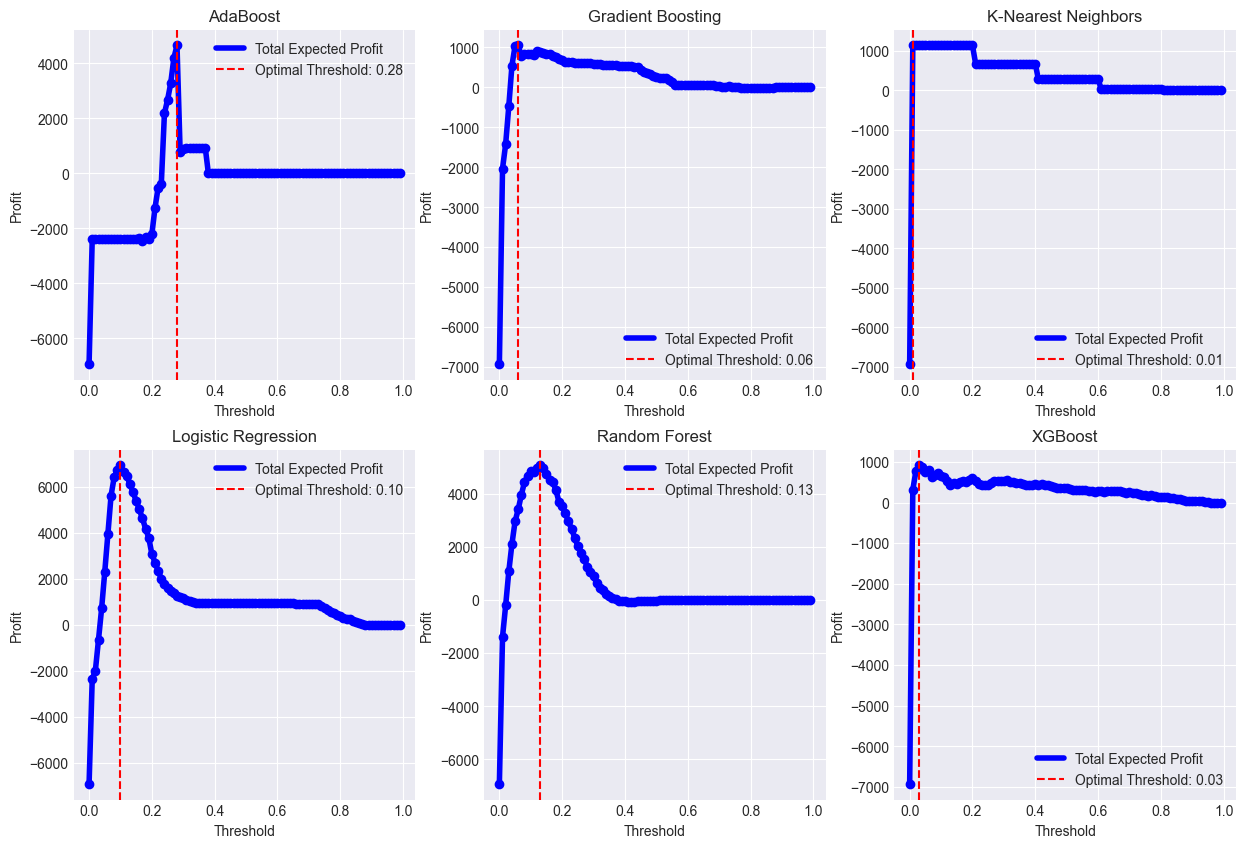

In [21]:
_, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (name, metric) in zip(axes.flatten(), metrics.items()):
    (
        thresholds,
        profits,
        maximum_profit,
        optimal_threshold,
        precision,
        recall,
    ) = metric
    plot_profit_thresholds(
        profits,
        thresholds,
        optimal_threshold,
        ax=ax,
        model_name=name,
    )

In [22]:
# Prepare headers and metrics for the table
headers = ["Metric"] + list(results.keys())

table = []
for name, metric in metrics.items():
    # Collect metrics for each model in a more elegant way
    values = [
        metric[2],  # Maximum Profit
        metric[3],  # Optimal Threshold
        metric[4],  # Precision
        metric[5],  # Recall
    ]
    if len(table) == 0:
        metric_names = [
            "Maximum Profit",
            "Optimal Threshold",
            "Precision",
            "Recall",
        ]
        table = [[name] for name in metric_names]
    for i, value in enumerate(values):
        if isinstance(value, float):
            table[i].append(f"{value:.3f}")
        else:
            table[i].append(f"{value:,}" if isinstance(value, int) else str(value))


print(tabulate(table, headers, tablefmt="github"))

| Metric            | AdaBoost   | Gradient Boosting   | K-Nearest Neighbors   | Logistic Regression   | Random Forest   |   XGBoost |
|-------------------|------------|---------------------|-----------------------|-----------------------|-----------------|-----------|
| Maximum Profit    | 4,654      | 1,050               | 1,133                 | 6,921                 | 5,075           |   911     |
| Optimal Threshold | 0.280      | 0.060               | 0.010                 | 0.100                 | 0.130           |     0.03  |
| Precision         | 0.165      | 0.109               | 0.114                 | 0.214                 | 0.162           |     0.107 |
| Recall            | 0.375      | 0.410               | 0.288                 | 0.413                 | 0.423           |     0.447 |


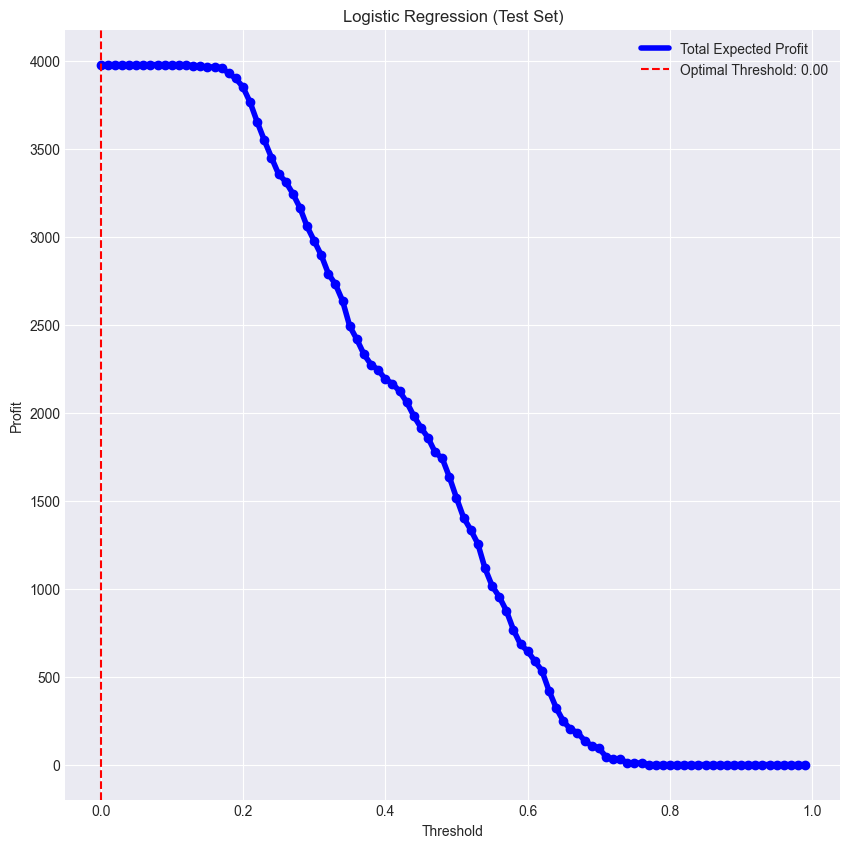

| Metric            | Value   |
|-------------------|---------|
| Maximum Profit    | 3,977   |
| Optimal Threshold | 0.000   |
| Precision         | 0.398   |
| Recall            | 1.000   |


In [24]:
selected_model = classifiers["Logistic Regression"][0]
selected_model.fit(X_train_transformed, y_train)
y_probs = selected_model.predict_proba(transformer.transform(X_test))[:, 1]
test_metrics = calculate_profit_thresholds(y_test, y_probs)

# Plot the profit thresholds for the selected model
fig, ax = plt.subplots(figsize=(10, 10))
plot_profit_thresholds(
    test_metrics[1],  # Profits
    test_metrics[0],  # Thresholds
    test_metrics[3],  # Optimal Threshold
    ax=ax,
    model_name="Logistic Regression (Test Set)",
)
plt.show()

headers = ["Metric", "Value"]
table = [
    ["Maximum Profit", f"{test_metrics[2]:,}"],
    ["Optimal Threshold", f"{test_metrics[3]:.3f}"],
    ["Precision", f"{test_metrics[4]:.3f}"],
    ["Recall", f"{test_metrics[5]:.3f}"],
]
print(tabulate(table, headers, tablefmt="github"))